In [2]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping

In [3]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [4]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [5]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 17)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

      unrate  psr       m2    dspic      pce    reer       

In [6]:
ticker='TSLA'

In [7]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [8]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [9]:
dates = pd.to_datetime(df['Date'])

In [10]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [11]:
df_for_training = df[cols].astype(float)

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [13]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [14]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [15]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [16]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [17]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 16)
(1251, 1)


In [18]:
size=1125
X_train=X[0:size,:]
X_test=X[size:,:]
y_train=y[0:size,:]
y_test=y[size:,:]


#early stopping


2023-11-06 20:45:00.280659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:45:00.320557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:45:00.320597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


2023-11-06 20:45:00.339827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:45:00.339887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:45:00.339903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:45:00.566299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:45:00.566345: I tensorflow/compile

Epoch 1/100


2023-11-06 20:45:32.337661: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-06 20:45:35.433749: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc37ca9fe80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-06 20:45:35.433815: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-11-06 20:45:35.467767: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-06 20:45:35.509510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-11-06 20:45:35.629381: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 [==============================] - 5s 117ms/step - loss: 0.0783 - val_loss: 0.0424
Epoch 2/100
4/4 [==============================] - 0s 58ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 3/100
4/4 [==============================] - 0s 60ms/step - loss: 0.0143 - val_loss: 0.0079
Epoch 4/100
4/4 [==============================] - 0s 54ms/step - loss: 0.0212 - val_loss: 0.0037
Epoch 5/100
4/4 [==============================] - 0s 58ms/step - loss: 0.0102 - val_loss: 0.0043
Epoch 6/100
4/4 [==============================] - 0s 57ms/step - loss: 0.0042 - val_loss: 0.0106
Epoch 7/100
4/4 [==============================] - 0s 56ms/step - loss: 0.0042 - val_loss: 0.0118
Epoch 8/100
4/4 [==============================] - 0s 51ms/step - loss: 0.0035 - val_loss: 0.0072
Epoch 9/100
4/4 [==============================] - 0s 51ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 10/100
4/4 [==============================] - 0s 50ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 11/100
4/4 [============

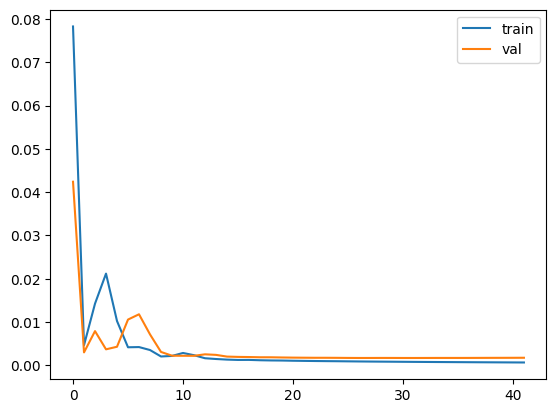

4/4 [==============================] - 0s 5ms/step
mae: 3.6505986478939962
(126,)
(126,)


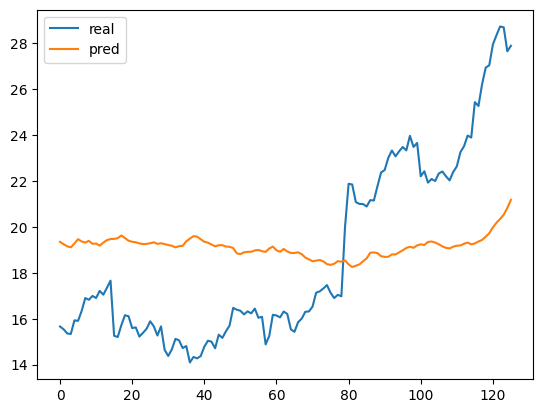

Epoch 1/100
7/7 [==============================] - 2s 70ms/step - loss: 0.0444 - val_loss: 0.0132
Epoch 2/100
7/7 [==============================] - 0s 44ms/step - loss: 0.0094 - val_loss: 0.0362
Epoch 3/100
7/7 [==============================] - 0s 47ms/step - loss: 0.0104 - val_loss: 0.0116
Epoch 4/100
7/7 [==============================] - 0s 44ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 5/100
7/7 [==============================] - 0s 47ms/step - loss: 0.0050 - val_loss: 0.0071
Epoch 6/100
7/7 [==============================] - 0s 42ms/step - loss: 0.0026 - val_loss: 0.0102
Epoch 7/100
7/7 [==============================] - 0s 41ms/step - loss: 0.0024 - val_loss: 0.0073
Epoch 8/100
7/7 [==============================] - 0s 39ms/step - loss: 0.0020 - val_loss: 0.0051
Epoch 9/100
7/7 [==============================] - 0s 38ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 10/100
7/7 [==============================] - 0s 44ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 11/100
7/7 [=

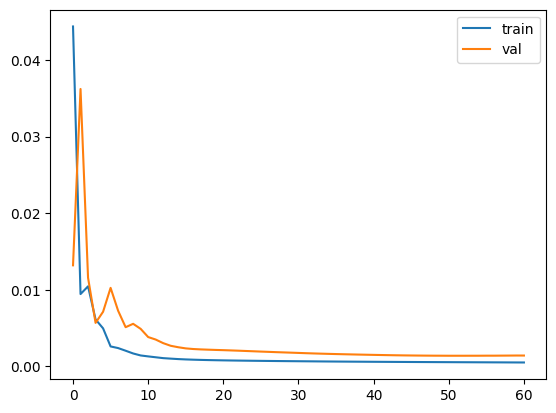

4/4 [==============================] - 0s 4ms/step
mae: 4.525955401377844
(126,)
(126,)


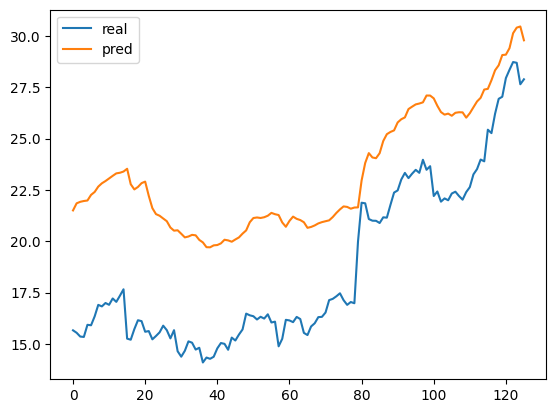

Epoch 1/100
10/10 [==============================] - 2s 55ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 2/100
10/10 [==============================] - 0s 43ms/step - loss: 0.0050 - val_loss: 0.0083
Epoch 3/100
10/10 [==============================] - 0s 40ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 4/100
10/10 [==============================] - 0s 42ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 5/100
10/10 [==============================] - 0s 41ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 6/100
10/10 [==============================] - 0s 43ms/step - loss: 9.2909e-04 - val_loss: 0.0018
Epoch 7/100
10/10 [==============================] - 0s 43ms/step - loss: 8.4996e-04 - val_loss: 0.0017
Epoch 8/100
10/10 [==============================] - 0s 43ms/step - loss: 8.0765e-04 - val_loss: 0.0013
Epoch 9/100
10/10 [==============================] - 0s 41ms/step - loss: 7.7391e-04 - val_loss: 0.0012
Epoch 10/100
10/10 [==============================] - 0s 42ms/step - loss: 7.8028e-0

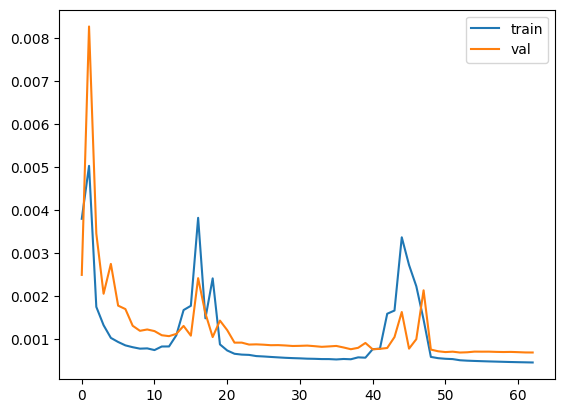

4/4 [==============================] - 0s 7ms/step
mae: 1.0183193187599788
(126,)
(126,)


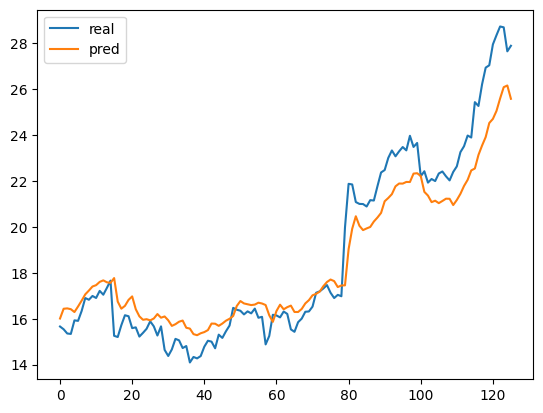

Epoch 1/100
13/13 [==============================] - 2s 56ms/step - loss: 0.0262 - val_loss: 0.0143
Epoch 2/100
13/13 [==============================] - 1s 45ms/step - loss: 0.0198 - val_loss: 0.0023
Epoch 3/100
13/13 [==============================] - 1s 42ms/step - loss: 0.0067 - val_loss: 0.0044
Epoch 4/100
13/13 [==============================] - 1s 42ms/step - loss: 0.0047 - val_loss: 0.0080
Epoch 5/100
13/13 [==============================] - 1s 46ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 6/100
13/13 [==============================] - 1s 42ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 7/100
13/13 [==============================] - 1s 44ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 8/100
13/13 [==============================] - 1s 42ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 9/100
13/13 [==============================] - 1s 42ms/step - loss: 9.9180e-04 - val_loss: 0.0020
Epoch 10/100
13/13 [==============================] - 1s 44ms/step - loss: 9.5529e-04 - val_loss

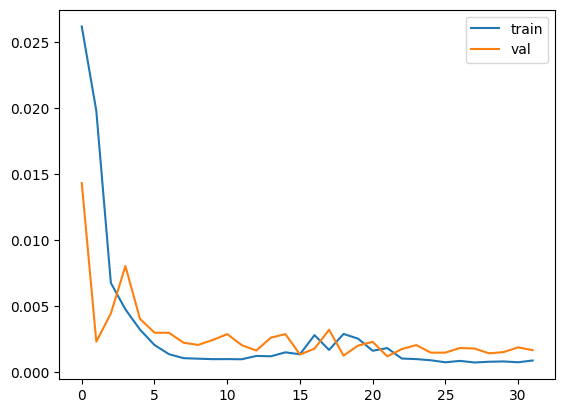

4/4 [==============================] - 0s 5ms/step
mae: 1.3214298084959
(126,)
(126,)


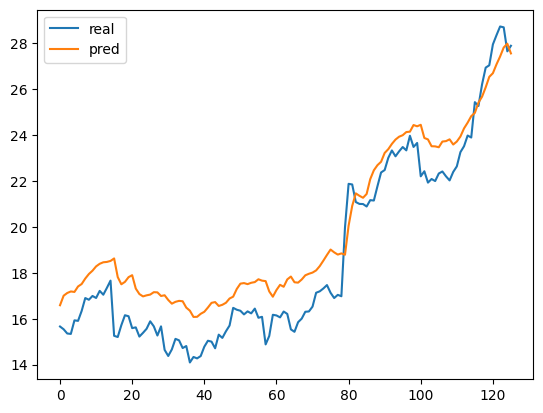

Epoch 1/100
17/17 [==============================] - 3s 67ms/step - loss: 0.0271 - val_loss: 0.0372
Epoch 2/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0341 - val_loss: 0.0606
Epoch 3/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0114 - val_loss: 0.0520
Epoch 4/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0059 - val_loss: 0.0302
Epoch 5/100
17/17 [==============================] - 1s 45ms/step - loss: 0.0028 - val_loss: 0.0340
Epoch 6/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0022 - val_loss: 0.0258
Epoch 7/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0019 - val_loss: 0.0219
Epoch 8/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0018 - val_loss: 0.0200
Epoch 9/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0016 - val_loss: 0.0169
Epoch 10/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0014 - val_loss: 0.0133

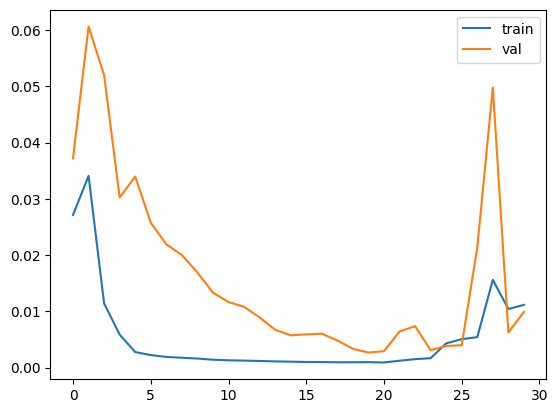

4/4 [==============================] - 0s 4ms/step
mae: 1.8756949870789545
(126,)
(126,)


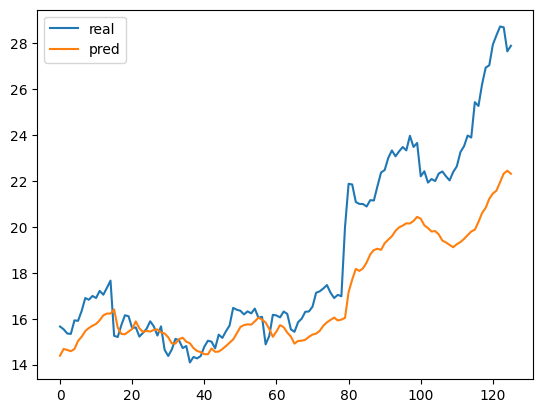

Epoch 1/100
20/20 [==============================] - 2s 42ms/step - loss: 0.0220 - val_loss: 0.0318
Epoch 2/100
20/20 [==============================] - 1s 36ms/step - loss: 0.0280 - val_loss: 0.0188
Epoch 3/100
20/20 [==============================] - 1s 41ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 4/100
20/20 [==============================] - 1s 37ms/step - loss: 0.0055 - val_loss: 0.0093
Epoch 5/100
20/20 [==============================] - 1s 38ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 6/100
20/20 [==============================] - 1s 42ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 7/100
20/20 [==============================] - 1s 36ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 8/100
20/20 [==============================] - 1s 36ms/step - loss: 0.0042 - val_loss: 0.0102
Epoch 9/100
20/20 [==============================] - 1s 36ms/step - loss: 0.0045 - val_loss: 0.0068
Epoch 10/100
20/20 [==============================] - 1s 36ms/step - loss: 0.0060 - val_loss: 0.0037

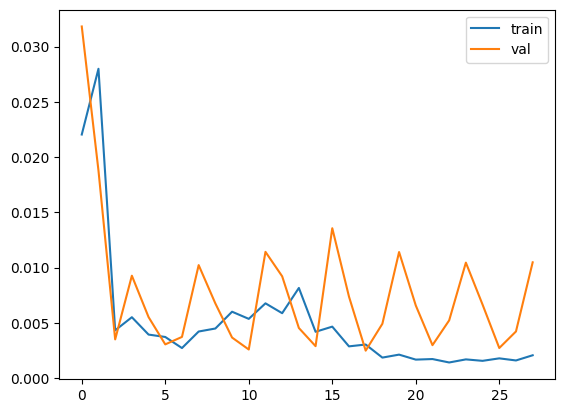

4/4 [==============================] - 0s 4ms/step
mae: 2.842223194599455
(126,)
(126,)


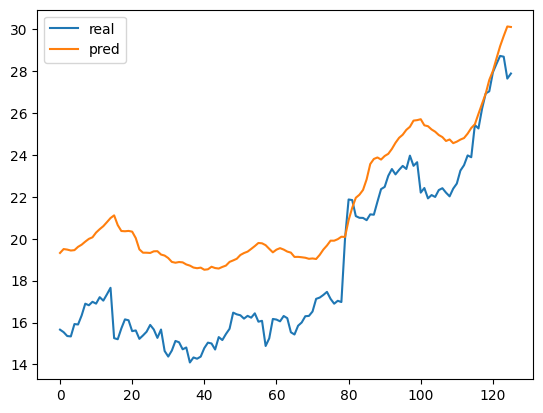

Epoch 1/100
23/23 [==============================] - 2s 40ms/step - loss: 0.0906 - val_loss: 0.0052
Epoch 2/100
23/23 [==============================] - 1s 35ms/step - loss: 0.0352 - val_loss: 0.0046
Epoch 3/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0056 - val_loss: 0.0069
Epoch 4/100
23/23 [==============================] - 1s 42ms/step - loss: 0.0065 - val_loss: 0.0152
Epoch 5/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0053 - val_loss: 0.0129
Epoch 6/100
23/23 [==============================] - 1s 37ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 7/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0037 - val_loss: 0.0053
Epoch 8/100
23/23 [==============================] - 1s 34ms/step - loss: 0.0043 - val_loss: 0.0092
Epoch 9/100
23/23 [==============================] - 1s 33ms/step - loss: 0.0066 - val_loss: 0.0116
Epoch 10/100
23/23 [==============================] - 1s 35ms/step - loss: 0.0079 - val_loss: 0.0030

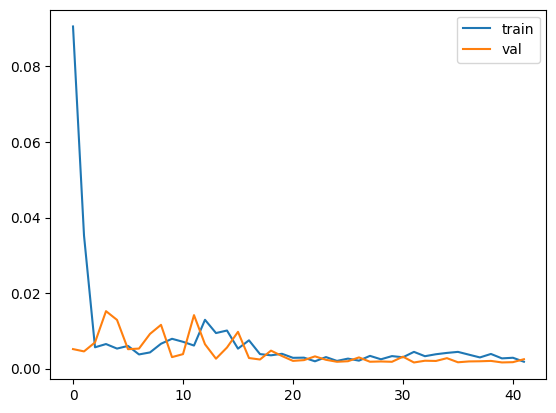

4/4 [==============================] - 0s 4ms/step
mae: 0.9397068133147708
(126,)
(126,)


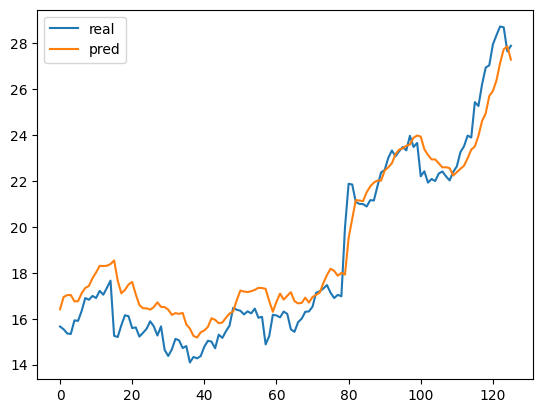

Epoch 1/100
26/26 [==============================] - 2s 41ms/step - loss: 0.0696 - val_loss: 0.0183
Epoch 2/100
26/26 [==============================] - 1s 38ms/step - loss: 0.0254 - val_loss: 0.0343
Epoch 3/100
26/26 [==============================] - 1s 35ms/step - loss: 0.0158 - val_loss: 0.0090
Epoch 4/100
26/26 [==============================] - 1s 35ms/step - loss: 0.0070 - val_loss: 0.0130
Epoch 5/100
26/26 [==============================] - 1s 34ms/step - loss: 0.0054 - val_loss: 0.0179
Epoch 6/100
26/26 [==============================] - 1s 35ms/step - loss: 0.0056 - val_loss: 0.0101
Epoch 7/100
26/26 [==============================] - 1s 35ms/step - loss: 0.0026 - val_loss: 0.0051
Epoch 8/100
26/26 [==============================] - 1s 34ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 9/100
26/26 [==============================] - 1s 35ms/step - loss: 0.0025 - val_loss: 0.0070
Epoch 10/100
26/26 [==============================] - 1s 35ms/step - loss: 0.0046 - val_loss: 0.0094

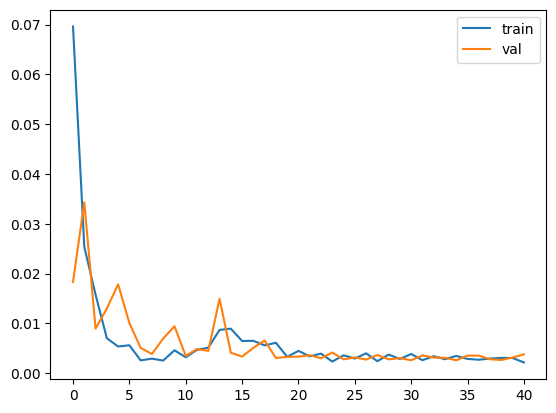

4/4 [==============================] - 0s 5ms/step
mae: 1.4024125401577423
(126,)
(126,)


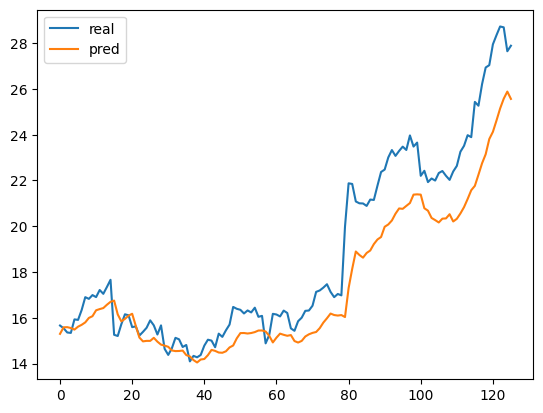

Epoch 1/100
29/29 [==============================] - 3s 43ms/step - loss: 0.0416 - val_loss: 0.0168
Epoch 2/100
29/29 [==============================] - 1s 42ms/step - loss: 0.0104 - val_loss: 0.0112
Epoch 3/100
29/29 [==============================] - 1s 37ms/step - loss: 0.0254 - val_loss: 0.0457
Epoch 4/100
29/29 [==============================] - 1s 37ms/step - loss: 0.0172 - val_loss: 0.0124
Epoch 5/100
29/29 [==============================] - 1s 35ms/step - loss: 0.0142 - val_loss: 0.0165
Epoch 6/100
29/29 [==============================] - 1s 33ms/step - loss: 0.0163 - val_loss: 0.0207
Epoch 7/100
29/29 [==============================] - 1s 34ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 8/100
29/29 [==============================] - 1s 34ms/step - loss: 0.0145 - val_loss: 0.0181
Epoch 9/100
29/29 [==============================] - 1s 34ms/step - loss: 0.0130 - val_loss: 0.0071
Epoch 10/100
29/29 [==============================] - 1s 33ms/step - loss: 0.0057 - val_loss: 0.0118

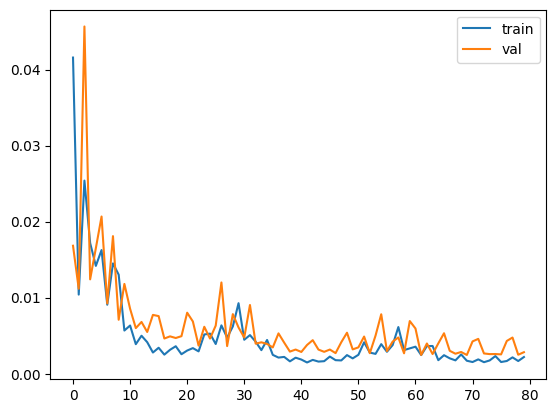

4/4 [==============================] - 0s 4ms/step
mae: 0.8220447069644021
(126,)
(126,)


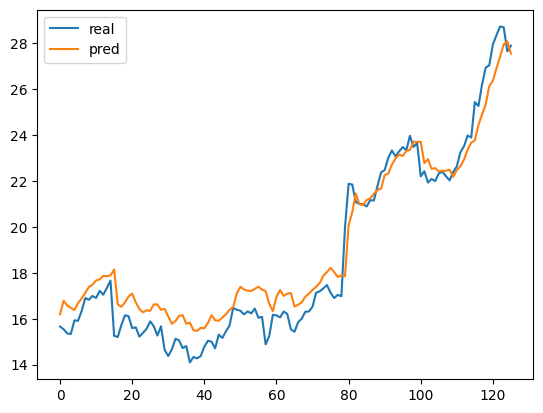

Epoch 1/100
32/32 [==============================] - 2s 37ms/step - loss: 0.0442 - val_loss: 0.0279
Epoch 2/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0222 - val_loss: 0.0568
Epoch 3/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0384 - val_loss: 0.1082
Epoch 4/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0132 - val_loss: 0.0274
Epoch 5/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0132 - val_loss: 0.0030
Epoch 6/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0092 - val_loss: 0.0038
Epoch 7/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0089 - val_loss: 0.0168
Epoch 8/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0168 - val_loss: 0.0407
Epoch 9/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0059 - val_loss: 0.0148
Epoch 10/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0063 - val_loss: 0.0025

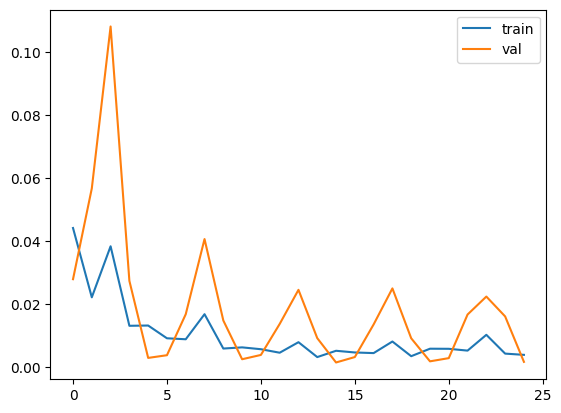

4/4 [==============================] - 0s 4ms/step
mae: 0.6615988046831405
(126,)
(126,)


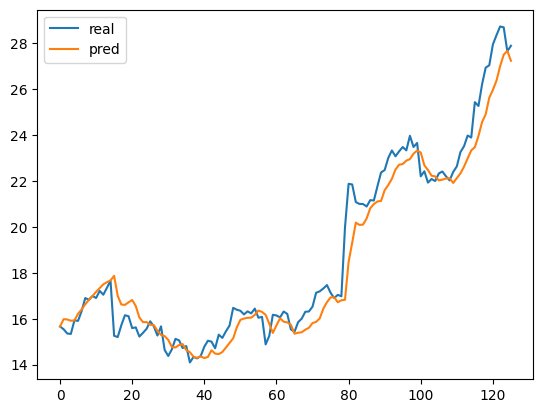

In [19]:
tscv = TimeSeriesSplit(n_splits=10)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=10)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model=Sequential()
    model.add(Bidirectional(GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False)))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')
  
    history=model.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape

    pred=np.repeat(y_pred,16,axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    
    print('mae:',np.mean(np.abs(pred-y_test)))

    print(pred.shape)
    print(y_test.shape)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()
